In [1]:
%pip install seaborn
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ReLU, Dense
from tensorflow.keras import Model

/Users/daryl/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
gpus

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


In [9]:
#Conv-BatchNorm-ReLU block

def conv_batchnorm_relu(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    return x

In [10]:
#Identity block

def identity_block(tensor, filters):
    
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)
    
    x = Add()([tensor,x])    #skip connection
    x = ReLU()(x)
    
    return x

In [11]:
#Projection block

def projection_block(tensor, filters, strides):
    
    #left stream
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=strides)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)
    
    #right stream
    shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut,x])    #skip connection
    x = ReLU()(x)
    
    return x

In [12]:
#Resnet block

def resnet_block(x, filters, reps, strides):
    
    x = projection_block(x, filters, strides)
    for _ in range(reps-1):
        x = identity_block(x,filters)
        
    return x

In [13]:
#Model
# CONSTANTS
imagesize = 32
OUTPUT = 4

input = Input(shape=(imagesize,imagesize,3))

x = conv_batchnorm_relu(input, filters=64, kernel_size=7, strides=2)
x = MaxPool2D(pool_size = 3, strides =2)(x)
x = resnet_block(x, filters=64, reps =3, strides=1)
x = resnet_block(x, filters=128, reps =4, strides=2)
x = resnet_block(x, filters=256, reps =6, strides=2)
x = resnet_block(x, filters=512, reps =3, strides=2)
x = GlobalAvgPool2D()(x)

output = Dense(OUTPUT, activation ='softmax')(x)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 16, 16,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_49 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 64)  │          0 │ re_lu_49[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 7, 7, 64)  │      4,160 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_50 (ReLU)     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 7, 7, 64)  │     36,928 │ re_lu_50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_51 (ReLU)     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 7, 7, 256) │     16,640 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 7, 7, 256) │     16,640 │ re_lu_51[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 7, 7, 256) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_52 (ReLU)     │ (None, 7, 7, 256) │          0 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 7, 7, 64)  │     16,448 │ re_lu_52[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
import os

In [15]:
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 5

CLASS_MODE = 'categorical'

CLASSES = ['normal','cataract','diabetic_retinopathy', 'glaucoma']


In [16]:
from tensorflow.keras import optimizers

sgd = optimizers.Adam(learning_rate= 0.0001)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [ ]:
# load your google drive


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rescale=1.0/255.0)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        'dataset/train',
        target_size=(imagesize, imagesize),
        class_mode=CLASS_MODE,
        classes=CLASSES)

validation_generator = data_generator.flow_from_directory(
        'dataset/dev',
        target_size=(imagesize, imagesize),
        class_mode=CLASS_MODE,
        classes=CLASSES
) 

Found 12 images belonging to 4 classes.
Found 12 images belonging to 4 classes.


In [21]:
fit_history = model.fit(
        train_generator,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator
)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2500 - loss: 1.8523 - val_accuracy: 0.6667 - val_loss: 1.3613
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step - accuracy: 0.2500 - loss: 1.4888 - val_accuracy: 0.3333 - val_loss: 1.3547
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - accuracy: 0.4167 - loss: 1.4632 - val_accuracy: 0.3333 - val_loss: 1.3530
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.1667 - loss: 2.4789 - val_accuracy: 0.3333 - val_loss: 1.3467
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step - accuracy: 0.3333 - loss: 2.0443 - val_accuracy: 0.3333 - val_loss: 1.3363


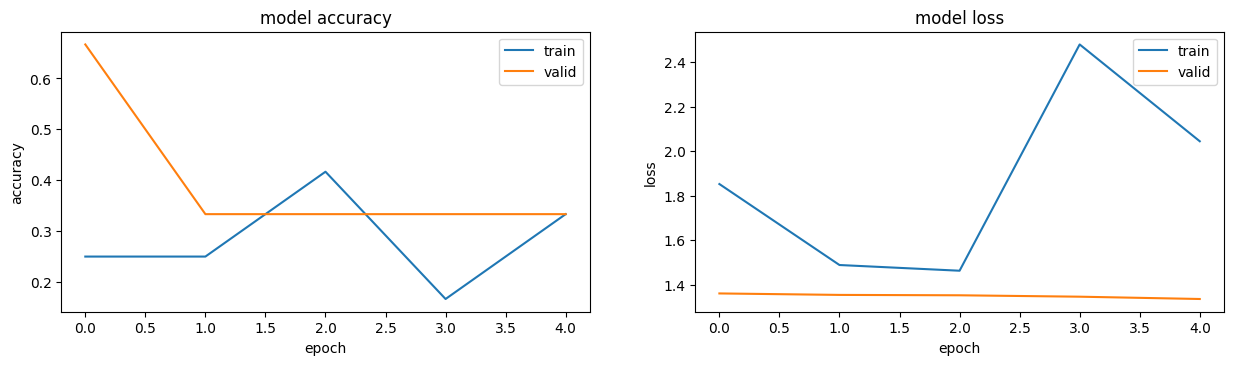

In [22]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

testingData = ImageDataGenerator(rescale=1.0/255.0)

testdata = data_generator.flow_from_directory(
    'dataset/test',
    target_size=(imagesize, imagesize),  # Change this to the input size of your model
    class_mode='categorical',  # or 'binary' depending on your model
    shuffle=False,
    classes= CLASSES
)

# Make predictions on the test set
test_loss, test_accuracy = model.evaluate(testdata)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

y_true = testdata.classes
y_pred_probs = model.predict(testdata, steps = None)

print("testdata.samples:", testdata.samples)
print("len(y_true):", len(y_true))

y_pred = np.argmax(y_pred_probs, axis=1)
print("y_pred: ", len(y_pred));

# # Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate sensitivity (recall)
sensitivity = recall_score(y_true, y_pred, average='weighted')

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity (Recall):", sensitivity)

Found 12 images belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.3333 - loss: 1.3451


/Users/daryl/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 1.3450689315795898
Test Accuracy: 0.3333333432674408
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
testdata.samples: 12
len(y_true): 12
y_pred:  12
Confusion Matrix:
[[4 0 0]
 [4 0 0]
 [4 0 0]]
Accuracy: 0.3333333333333333
Precision: 0.1111111111111111
Sensitivity (Recall): 0.3333333333333333


/Users/daryl/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
model.save("model.keras")

In [28]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your pre-trained model
model = tf.keras.models.load_model("model.keras")

# Create the test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Specify the path to your test set
test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(imagesize, imagesize),  # Change this to the input size of your model
    class_mode='categorical',  # or 'binary' depending on your model
    shuffle=False,
    classes= CLASSES
)

# Evaluate the model using the generator
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Accuracy: {accuracy}")

# Get predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix")
print(cm)

# Calculate additional metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
error_rate = 1 - accuracy

print(f"Precision: {precision}")
print(f"Sensitivity (Recall): {recall}")
print(f"Error Rate: {error_rate}")

# Classification Report
print("Classification Report")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Found 12 images belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3333 - loss: 1.3451


/Users/daryl/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Accuracy: 0.3333333432674408
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion Matrix
[[4 0 0]
 [4 0 0]
 [4 0 0]]
Precision: 0.1111111111111111
Sensitivity (Recall): 0.3333333333333333
Error Rate: 0.6666666567325592
Classification Report


/Users/daryl/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter